In [221]:
import random
import json
import re
import os, sys
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

WORK_DIR = Path.cwd().parent
sys.path.append(str(WORK_DIR))

from src import response_processing as rp
from src.viz_utils import qa_viz

random.seed(6)
np.random.seed(6)

STAR_VAL_SMALL = WORK_DIR / "data/datasets/STAR/STAR_annotations/STAR_val_small_1000.json"
VQA_RESP_FILEPATH = WORK_DIR / "outputs/vqa_gemma3:4b-it-qat_20250619_20:59:00.jsonl"
VQA_RESP_WOUT_NONE_ALTERNATIVE_FILEPATH = WORK_DIR / "outputs/vqa_without_noneoftheothers_alt_gemma3:4b-it-qat_20250622_23:17:00.jsonl"
#QA_GEN_GRAPHS = WORK_DIR / "outputs/responses_to_genframes_gemma3:4b-it-qat_20250605_00:00:00.jsonl"
QA_GEN_GRAPHS = WORK_DIR / "outputs/responses_on_small_val_gemma3:4b-it-qat_20250609_21:50:00.jsonl"


# Experiment
### Comparison between VQA and QA on generated frames - same sample rate


**Parameters:**
- model: Gemma3:4b-it-qat
- user_prompt: vqa/user_prompt_v2.txt
- temperature: 0.1
- sampling method: (default) top-p (p=0.9)

## Prompts

In [222]:
with open('../data/prompts/vqa/user_prompt_v2.txt', 'r') as f:
    pr = f.read()

print(pr)


You are an intelligent video comprehension model and are going to receive as input a sequence of images extracted from a video and a question. You need to analyze and describe the scene unfolding in the video (sequence of frames) following these guidelines:
1. Look for recurring objects;
2. Note that the same object may appear differently across frames due to low image quality, varying viewing angles, or partial obstructions. Carefully check objects with similar features (e.g. shape, color), appearing in different frames, as they may still be the same object;
3. Pay attention to how the person interacts with its environment
4. Understand the directional movement of the people and objects in the video
5. Carefully analyze the chronological sequence of the events occurring in the video;
6. Pay attention to the atomic and fine grained movement, pose and actions of the people in the video. Compose these atomic actions happening across the frame to infer the higher level action performed by

In [223]:
with open('../data/prompts/zero-shot-cot/auto_reply_ZS_CoT.txt', 'r') as f:
    pr = f.read()

print(pr)


Therefore the final answer is?

Your response must be provided in valid JSON format as follows:
{"answer": "your complete answer here"}

IMPORTANT: Always include both the letter (A, B, C, D, etc.) AND the full text of the answer in your response.
Do not abbreviate or shorten the answer. For example, if the correct answer is "A. the laptop", your response 
should be {"answer": "A. the laptop"}, not {"answer": "laptop"} or {"answer": "A"}.\



Let's load the ground truth from the `STAR_QA_question_and_stsg_val.json` file where we extracted QA and spatio-temporal scene graphs

In [224]:
ground_truth = []

with open('../data/datasets/STAR/STAR_annotations/STAR_val_small_1000.json') as f:
    data = json.load(f)
    ground_truth = [{
        'id': sample['question_id'],
        'question': sample['question'],
        'choices': sample['choices'],
        'text': sample['answer'],
    } for sample in data]


# we keep num as str so we can directrly access choices dictionaries
gt_df = pd.DataFrame(ground_truth).astype({'id': 'string', 'text': 'string'})
gt_df.set_index('id', inplace=True)
gt_df


,question,choices,text
id,,,
Feasibility_T5_102,Which object is the person able to throw after...,"[{'choice_id': 0, 'choice': 'The bag.', 'choic...",The clothes.
Feasibility_T2_860,What else is the person able to do with the wi...,"[{'choice_id': 0, 'choice': 'Lie on the window...",Close the window.
Feasibility_T2_556,What else is the person able to do with the cl...,"[{'choice_id': 0, 'choice': 'Tidy up the close...",Open the closet/cabinet.
Prediction_T1_2539,What will the person do next?,"[{'choice_id': 0, 'choice': 'Sit on the floor....",Sit on the floor.
Prediction_T4_1253,Which object would the person throw next after...,"[{'choice_id': 0, 'choice': 'The pillow.', 'ch...",The shoe.
...,...,...,...
Interaction_T1_8913,Which object was taken by the person?,"[{'choice_id': 0, 'choice': 'The paper/noteboo...",The paper/notebook.
Interaction_T1_8967,Which object was taken by the person?,"[{'choice_id': 0, 'choice': 'The towel.', 'cho...",The dish.
Interaction_T2_1847,What did the person do with the paper/notebook?,"[{'choice_id': 0, 'choice': 'Put down.', 'choi...",Took.


## Loading predicted answers evaluation

In [225]:
gt_df = None
with open(STAR_VAL_SMALL, 'r') as f:
    gt_df = pd.read_json(f)

gt_df = gt_df.rename(columns={'answer': 'text'})
gt_df = gt_df.set_index('question_id')
gt_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1048 entries, Feasibility_T5_102 to Interaction_T4_4181
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   question          1048 non-null   object 
 1   video_id          1048 non-null   object 
 2   start             1048 non-null   float64
 3   end               1048 non-null   float64
 4   text              1048 non-null   object 
 5   question_program  1048 non-null   object 
 6   choices           1048 non-null   object 
 7   situations        1048 non-null   object 
dtypes: float64(2), object(6)
memory usage: 73.7+ KB


In [226]:
pred_vqa_df = rp.gemma3_ans_extract(VQA_RESP_WOUT_NONE_ALTERNATIVE_FILEPATH)
pred_gg_df = rp.gemma3_ans_extract(QA_GEN_GRAPHS)


Total answers: 1048
Answers following JSON template: 1048
Percentage following JSON template: 100.00%
Answer following the template: 1021
97.42% of the total

Only 27 samples do not contain the answer in the response with the specified format


/home/lusha/star_code/src/response_processing.py:178: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  contains_answer = predictions_df["answer"].str.contains(


Total answers: 1030
Answers following JSON template: 1030
Percentage following JSON template: 100.00%
Answer following the template: 838
81.36% of the total

Only 192 samples do not contain the answer in the response with the specified format


/home/lusha/star_code/src/response_processing.py:178: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  contains_answer = predictions_df["answer"].str.contains(


In [227]:
pred_vqa_df.rename(columns={'answer': 'pred_text'}, inplace=True)
eval_df1 = gt_df.join(
    pred_vqa_df, 
    how='inner' # we account also for samples without answers
)
rp.print_acc(eval_df1, lambda x: rp.accuracy(x, on_what='text'))


Question type       Total      Accuracy 

Interaction          293        50.85%  
Sequence             279        48.75%  
Prediction           237        45.57%  
Feasibility          212        39.62%  

Average             1021        46.72%  


In [228]:
pred_gg_df.rename(columns={'answer': 'pred_text'}, inplace=True)
eval_df2 = gt_df.join(
    pred_gg_df, 
    how='inner' # we account also for samples without answers
)
rp.print_acc(eval_df2, lambda x: rp.accuracy(x, on_what='text'))


Question type       Total      Accuracy 

Interaction          221        39.82%  
Sequence             229        41.92%  
Prediction           210        41.43%  
Feasibility          178        42.70%  

Average              838        41.41%  


In [229]:
pred_vqa_df.rename(columns={'pred_text': 'pred_text1'}, inplace=True)
pred_gg_df.rename(columns={'pred_text': 'pred_text2'}, inplace=True)
eval_df_all = gt_df.join(
    pred_vqa_df[['pred_text1']],
    how='inner'
).join(
    pred_gg_df[['pred_text2']],
    how='inner'
)

eval_df_all['text'] = eval_df_all['text'].str.lower()
eval_df_all['pred_text1'] = eval_df_all['pred_text1'].str.lower()
eval_df_all['pred_text2'] = eval_df_all['pred_text2'].str.lower()
eval_df_all


,question,video_id,start,end,text,question_program,choices,situations,pred_text1,pred_text2
Feasibility_T5_102,Which object is the person able to throw after...,ATV2F,0.0,4.000,the clothes.,"[{'function': 'Situations', 'value_input': []}...","[{'choice_id': 0, 'choice': 'The bag.', 'choic...","{'000031': {'rel_pairs': [['o000', 'o019'], ['...",the bag.,the bag.
Feasibility_T2_860,What else is the person able to do with the wi...,9J166,9.9,17.500,close the window.,"[{'function': 'Situations', 'value_input': []}...","[{'choice_id': 0, 'choice': 'Lie on the window...","{'000321': {'rel_pairs': [['o000', 'o017'], ['...",hold the window.,open the window.
Feasibility_T2_556,What else is the person able to do with the cl...,ANA5N,4.3,10.300,open the closet/cabinet.,"[{'function': 'Situations', 'value_input': []}...","[{'choice_id': 0, 'choice': 'Tidy up the close...","{'000390': {'rel_pairs': [['o000', 'o011'], ['...",tidy up the closet/cabinet.,open the closet/cabinet.
Prediction_T1_2539,What will the person do next?,Z6HEA,0.0,10.875,sit on the floor.,"[{'function': 'Situations', 'value_input': []}...","[{'choice_id': 0, 'choice': 'Sit on the floor....","{'000021': {'rel_pairs': [['o000', 'o027'], ['...",open the bag.,sit on the floor.
Interaction_T1_5612,Which object was opened by the person?,AS7SG,22.1,31.000,the laptop.,"[{'function': 'Situations', 'value_input': []}...","[{'choice_id': 0, 'choice': 'The box.', 'choic...","{'000665': {'rel_pairs': [['o000', 'o028'], ['...",the laptop.,the laptop.
...,...,...,...,...,...,...,...,...,...,...
Interaction_T1_5491,Which object was taken by the person?,4P13T,0.0,4.800,the bag.,"[{'function': 'Situations', 'value_input': []}...","[{'choice_id': 0, 'choice': 'The towel.', 'cho...","{'000033': {'rel_pairs': [['o000', 'o023']], '...",the bag.,the bag.
Sequence_T5_6297,What did the person do to the towel after hold...,9632M,4.9,32.000,took.,"[{'function': 'Situations', 'value_input': []}...","[{'choice_id': 0, 'choice': 'Threw.', 'choice_...","{'000818': {'rel_pairs': [['o000', 'o028'], ['...",put down.,put down.
Sequence_T4_3501,What happened before the person held the sandw...,1ZBUS,5.2,21.800,sat at the table.,"[{'function': 'Situations', 'value_input': []}...","[{'choice_id': 0, 'choice': 'Sat at the table....","{'000315': {'rel_pairs': [['o000', 'o028'], ['...",sat at the table.,sat at the table.
Prediction_T4_1007,Which object would the person open next after ...,03M0K,0.0,9.100,the laptop.,"[{'function': 'Situations', 'value_input': []}...","[{'choice_id': 0, 'choice': 'The laptop.', 'ch...","{'000035': {'rel_pairs': [['o000', 'o019']], '...",the closet/cabinet.,the laptop.


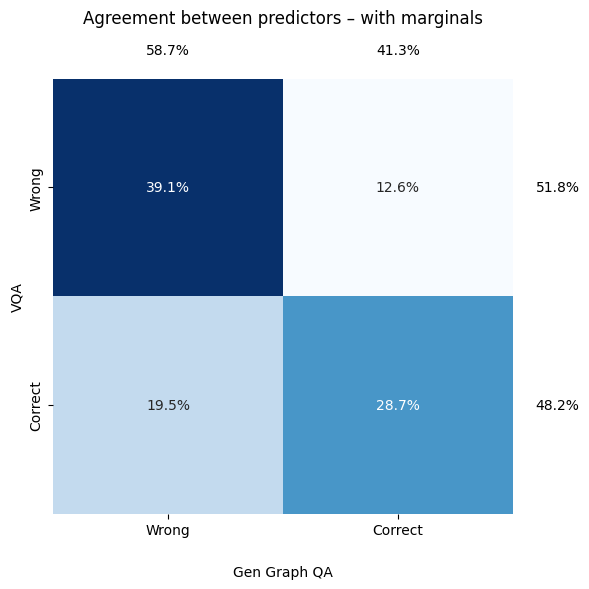

In [230]:
# your data
display_eval = eval_df_all
pred_vqa_correct = (display_eval['text'] == display_eval['pred_text1']).astype(int).values
pred_gg_correct  = (display_eval['text'] == display_eval['pred_text2']).astype(int).values
labels = ['Wrong', 'Correct']

# confusion matrix (normalized over all)
cm = confusion_matrix(pred_vqa_correct, pred_gg_correct, normalize='all')

# compute marginal sums and convert to % of total
row_totals = cm.sum(axis=1)
col_totals = cm.sum(axis=0)
total = cm.sum()
row_pct = row_totals / total
col_pct = col_totals / total

fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='.1%', cmap='Blues',
            xticklabels=labels, yticklabels=labels,
            cbar=False, ax=ax)

# annotate row marginals at the right of each row
for i, p in enumerate(row_pct):
    ax.text(len(labels) + 0.1,  i + 0.5, f'{p:.1%}', 
            va='center', ha='left', fontsize=10)

# annotate column marginals just above each column
for j, p in enumerate(col_pct):
    ax.text(j + 0.5, -0.1, f'{p:.1%}', 
            ha='center', va='bottom', fontsize=10)

# move x-axis labels (and xlabel) to the top
ax.set_xlabel('Gen Graph QA', labelpad=20)
ax.set_ylabel('VQA')
ax.set_title('Agreement between predictors – with marginals', pad=40)

# make xtick labels horizontal
ax.set_xticklabels(labels, rotation=0)

plt.tight_layout()
plt.show()


The graph above tell us the following insights:
- In ~20% the samples the VQA is able to guess the right response where the Graph based QA mistakes
- On the other hand, there's a significant 12% where the Graph based QA is correct and the VQA is wrong


In [231]:
vqa_correct_gg_wrong = pred_vqa_correct & ~pred_gg_correct
mask = vqa_correct_gg_wrong.astype(bool)


In [232]:
indices = eval_df_all[mask].index
test1 = indices[0]


In [233]:
qa_viz.compact_print_qa(
    test1, gt_df.rename(columns={'text': 'answer'}),
    [pred_vqa_df.rename(columns={'pred_text1': 'answer'}), pred_gg_df.rename(columns={'pred_text2': 'answer'})],
    ['VQA', 'GG-QA'])



┌─ Sample: Feasibility_T5_1851 ─────────────────────────────────────────────────────────────
│
│ Question:
│    Which object is the person able to close after taking the cup/glass/bottle?
│ Alternatives:
│    0. The door.
│    1. The book.
│    2. The laptop.
│    3. The closet/cabinet.
│
│ Ground Truth:
│    The laptop.
│
|
│ Model Predictions - VQA:
│    Prediction:  the laptop. [CORRECT]
│    Reasoning:
│        Okay, let’s analyze the video and respond to the question.
│        
│        **1. Question Interpretation:** The question asks which object the person is able to close after taking a drink from a cup/glass/bottle.
│        
│        **2. Video Analysis:**
│        
│        *   **Person:** The video shows a man sitting in a wheelchair. He is actively drinking from a cup/bottle.
│        *   **Objects in the Scene:** The scene contains a table with various items: a laptop, a Reese’s cup, a bottle of ketchup, a bottle of mustard, a bottle of mayonnaise, a book, and a cabinet

In [234]:
test1 = indices[1]
qa_viz.compact_print_qa(
    test1, gt_df.rename(columns={'text': 'answer'}),
    [pred_vqa_df.rename(columns={'pred_text1': 'answer'}), pred_gg_df.rename(columns={'pred_text2': 'answer'})],
    ['VQA', 'GG-QA'])



┌─ Sample: Prediction_T4_1828 ──────────────────────────────────────────────────────────────
│
│ Question:
│    Which object would the person close next after they hold the dish?
│ Alternatives:
│    0. The box.
│    1. The closet/cabinet.
│    2. The door.
│    3. The refrigerator.
│
│ Ground Truth:
│    The refrigerator.
│
|
│ Model Predictions - VQA:
│    Prediction:  The refrigerator. [CORRECT]
│    Reasoning:
│        Okay, let’s analyze the video and respond to the question.
│        
│        **1. Question Interpretation:** The question asks which object the person will close *after* they hold the dish. It’s a sequential question, requiring us to observe the person’s actions in order.
│        
│        **2. Video Analysis:**
│        
│        *   **Person:** A man is standing in a kitchen. He’s wearing a long-sleeved shirt.
│        *   **Dish:** He is holding a red pot.
│        *   **Refrigerator:** He is moving towards the refrigerator.
│        *   **Cabinet/Closet:** The

In [235]:
prev_analyzed = [
    "Interaction_T1_4054",
    "Interaction_T1_8913",
    "Interaction_T2_3423",
    "Interaction_T1_4115",
    "Interaction_T1_1168",
    "Interaction_T1_309",
    "Interaction_T1_4703",
    "Interaction_T1_2516",
    "Interaction_T1_8967",
    "Interaction_T1_5709",
    "Interaction_T1_2226",
    "Interaction_T1_111",
    "Interaction_T1_8274",
    "Interaction_T1_7254",
    "Interaction_T1_4221",
    #"Interaction_T1_3485",
    #"Interaction_T4_4181",
    #"Interaction_T2_1847",
]


In [238]:
pred_gg_df


,pred_text2,chat_history
id,,
Feasibility_T5_102,The bag.,"[{'role': 'user', 'content': 'Please carefully..."
Feasibility_T2_860,Open the window.,"[{'role': 'user', 'content': 'Please carefully..."
Feasibility_T2_556,Open the closet/cabinet.,"[{'role': 'user', 'content': 'Please carefully..."
Prediction_T1_2539,Sit on the floor.,"[{'role': 'user', 'content': 'Please carefully..."
Interaction_T1_5612,The laptop.,"[{'role': 'user', 'content': 'Please carefully..."
...,...,...
Interaction_T1_5491,The bag.,"[{'role': 'user', 'content': 'Please carefully..."
Sequence_T5_6297,Put down.,"[{'role': 'user', 'content': 'Please carefully..."
Sequence_T4_3501,Sat at the table.,"[{'role': 'user', 'content': 'Please carefully..."


In [237]:
pred_gg_df.loc[prev_analyzed]


KeyError: "['Interaction_T1_4054', 'Interaction_T1_8913', 'Interaction_T2_3423', 'Interaction_T1_1168', 'Interaction_T1_309', 'Interaction_T1_4703', 'Interaction_T1_2516', 'Interaction_T1_8967', 'Interaction_T1_5709', 'Interaction_T1_2226', 'Interaction_T1_111', 'Interaction_T1_8274', 'Interaction_T1_7254'] not in index"

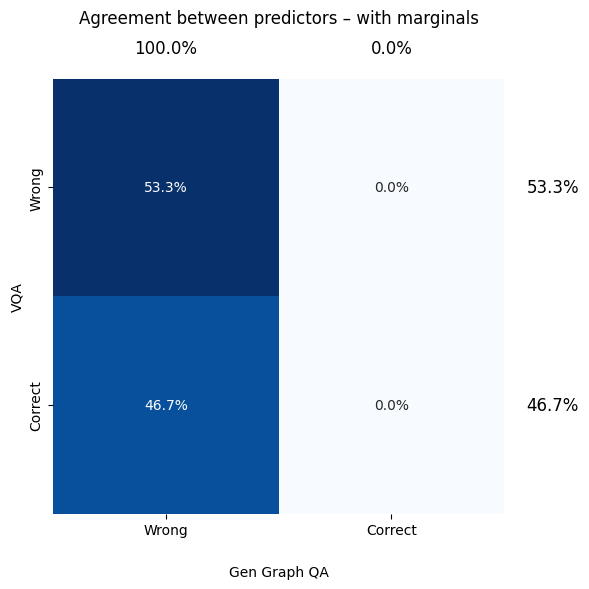

In [216]:
# your data
display_eval = eval_df_all.loc[prev_analyzed]
pred_vqa_correct = (display_eval['text'] == display_eval['pred_text1']).astype(int).values
pred_gg_correct  = (display_eval['text'] == display_eval['pred_text2']).astype(int).values
labels = ['Wrong', 'Correct']

# confusion matrix (normalized over all)
cm = confusion_matrix(pred_vqa_correct, pred_gg_correct, normalize='all')

# compute marginal sums and convert to % of total
row_totals = cm.sum(axis=1)
col_totals = cm.sum(axis=0)
total = cm.sum()
row_pct = row_totals / total
col_pct = col_totals / total

fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='.1%', cmap='Blues',
            xticklabels=labels, yticklabels=labels,
            cbar=False, ax=ax)

# annotate row marginals at the right of each row
for i, p in enumerate(row_pct):
    ax.text(len(labels) + 0.1,  i + 0.5, f'{p:.1%}', 
            va='center', ha='left', fontsize=12)

# annotate column marginals just above each column
for j, p in enumerate(col_pct):
    ax.text(j + 0.5, -0.1, f'{p:.1%}', 
            ha='center', va='bottom', fontsize=12)

# move x-axis labels (and xlabel) to the top
ax.set_xlabel('Gen Graph QA', labelpad=20)
ax.set_ylabel('VQA')
ax.set_title('Agreement between predictors – with marginals', pad=40)

# make xtick labels horizontal
ax.set_xticklabels(labels, rotation=0)

plt.tight_layout()
plt.show()
